Вводные данные:  
Рассматривается задача бинарной классификации. Пусть заданы два класса, распределение которых является многомерным нормальным (mu^(+) ∈ R^2 - параметр положительного класса (+1), mu^(-) - отрицательного (-1),  Σ ∈ R^(2×2) - общая для классов ковариационная матрица).

Задача 1.
Подобрать параметры распределений таким образом, чтобы классы немного пересекались (нельзя было разделить их линейной функцией)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

np.random.seed(42)

mu_pos = [2, 2]  # центр положительного класса
mu_neg = [0, 0]  # центр отрицательного класса
cov = [[1, 0.8], [0.8, 1]]  # общая ковариационная матрица

Задание 2.
Сгенерировать по N=30 объектов каждого класса. Разделить данные каждого класса на 3 равные по объему выборки (тренировочную, валидационную и тестовую)

In [8]:
N = 30

# Генерация данных каждого класса
class_pos = np.random.multivariate_normal(mu_pos, cov, N)
class_neg = np.random.multivariate_normal(mu_neg, cov, N)

# Разделение данных
def split_data(samples, n_splits=3):
    split_size = len(samples) // n_splits
    return samples[:split_size], samples[split_size:2*split_size], samples[2*split_size:]

train_pos, val_pos, test_pos = split_data(class_pos)
train_neg, val_neg, test_neg = split_data(class_neg)

# Объединение в общий массив
train_data = np.vstack((train_pos, train_neg))
val_data = np.vstack((val_pos, val_neg))
test_data = np.vstack((test_pos, test_neg))

train_labels = np.hstack((np.ones(len(train_pos)), -np.ones(len(train_neg))))
val_labels = np.hstack((np.ones(len(val_pos)), -np.ones(len(val_neg))))
test_labels = np.hstack((np.ones(len(test_pos)), -np.ones(len(test_neg))))

Задание 3. Реализовать и обучить модель логистической регрессии (логику написать самим). Построить на графике полученную разделяющую поверхность. Для нескольких объектов из обоих классов вывести оценки вероятностей их распределения по класса

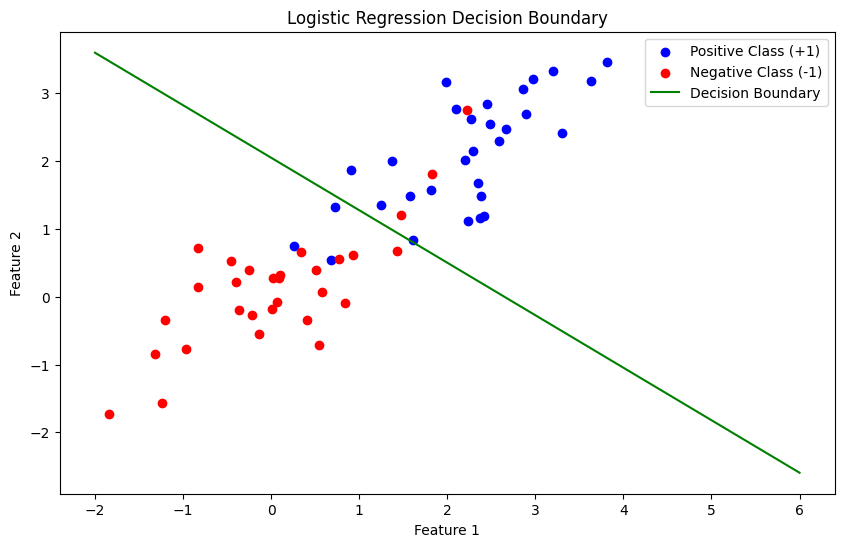

Probability estimates for validation data:
[0.2613808  0.7953906  0.92840904 0.97495441 0.93290044]


In [9]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate # скорость обучения, определяющая величину шага, с которым обновляются веса на каждом шаге
        self.num_iterations = num_iterations # количество итераций
        self.weights = None 
        self.bias = None

    def sigmoid(self, z): # преобразуем линейную комбинацию признаком в значения от 0 до 1
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y): 
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features) # веса
        self.bias = 0 # смещение

        # Градиентный спуск
        for i in range(self.num_iterations):
            model = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(model) # получаем вероятности

            # Вычисление градиентов
            # Они рассчитываются чтобы измерить как сильно каждый вес и смещение влияют на ошибку
            dw = (1 / num_samples) * np.dot(X.T, (predictions - y))
            db = (1 / num_samples) * np.sum(predictions - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_prob(self, X): # вычисляем вероятности
        model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(model)

    def predict(self, X, threshold=0.5): # предсказываем метки классов на основе порогового значения 0.5, т.е. P > 0.5 -> 1, P <= 0.5 -> -1
        probabilities = self.predict_prob(X)
        return np.where(probabilities > threshold, 1, 0)

# Подготовка данных
X_train = train_data
y_train = (train_labels + 1) / 2  # Преобразование меток в {0, 1}

X_val = val_data
y_val = (val_labels + 1) / 2

X_test = test_data
y_test = (test_labels + 1) / 2

# Обучение модели
model = LogisticRegression(learning_rate=0.1, num_iterations=1000)
model.fit(X_train, y_train)

# Построение разделяющей поверхности
x_values = np.linspace(-2, 6, 100)
# w1*x + w2*y + b = 0, => y = ...
y_values = -(model.weights[0] * x_values + model.bias) / model.weights[1]

plt.figure(figsize=(10, 6))
plt.scatter(class_pos[:, 0], class_pos[:, 1], color='blue', label='Positive Class (+1)')
plt.scatter(class_neg[:, 0], class_neg[:, 1], color='red', label='Negative Class (-1)')
plt.plot(x_values, y_values, color='green', label='Decision Boundary')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

# Вывод оценок вероятностей для нескольких объектов
print("Probability estimates for validation data:")
print(model.predict_prob(X_val[:5]))

Задание 4.
Определить оптимальный порог t, при котором на валидационной выборке определяются не менее 60% от поступающих положительных объектов: 𝑝̂(𝑦=+1|𝑥) ≡ 𝑎(𝑥) > 𝑡.

In [10]:
def find_optimal_threshold(model, X_val, y_val, target_recall=0.6):
    thresholds = np.linspace(0, 1, 100) # 100 пороговых значений от 0 до 1
    thresholds = thresholds[::-1]
    best_threshold = 0
    for t in thresholds:
        predictions = model.predict_prob(X_val) > t # вычисляем предсказания на валидационных данных. Если > t -> +1, если <= t -> -1
        recall = np.sum((predictions == 1) & (y_val == 1)) / np.sum(y_val == 1) # количество истинно положительных срабатываний / общее количество положительных объектов в выборке
        if recall >= target_recall:
            best_threshold = t
            break
    return best_threshold

optimal_threshold = find_optimal_threshold(model, X_val, y_val)
print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.8181818181818182


Задание 5.
На тестовой выборке оценить качество полученного алгоритма, рассчитав метрики (расчет метрик реализовать самим):  
a) Accuracy  
b) Матрица ошибок  
c) Precision, Recall  
d) ROC-кривая, ROC-AUC

Accuracy: 0.75 = 75.0% correct
Confusion Matrix:
[[10  0]
 [ 5  5]]
Precision: 1.0
Recall: 0.5


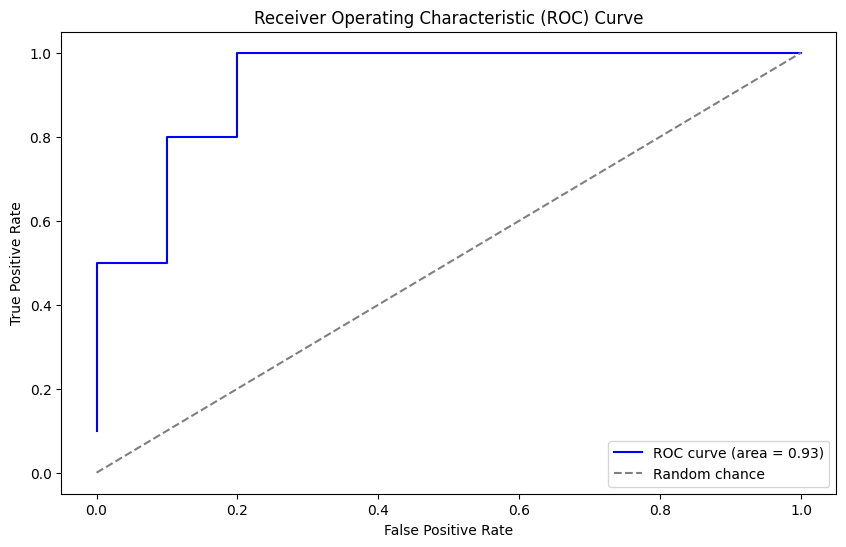

In [11]:
# Accuracy
y_pred = model.predict(X_test, threshold=optimal_threshold)

def accuracy_score_manual(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true) # количество правильных предсказаний / общее количество предсказанных элементов

accuracy = accuracy_score_manual(y_test, y_pred)
print(f"Accuracy: {accuracy} = {accuracy*100}% correct")

# Матрица ошибок
# True Positive (TP) — истинно положительные: количество объектов, которые фактически являются положительными и были классифицированы как положительные.
# True Negative (TN) — истинно отрицательные: количество объектов, которые фактически являются отрицательными и были классифицированы как отрицательные.
# False Positive (FP) — ложно положительные (ошибки первого рода): количество объектов, которые фактически являются отрицательными, но были классифицированы как положительные.
# False Negative (FN) — ложно отрицательные (ошибки второго рода): количество объектов, которые фактически являются положительными, но были классифицированы как отрицательные.
def confusion_matrix_manual(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

conf_matrix = confusion_matrix_manual(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, Recall
# Precision = tp / (tp + fp)
def precision_score_manual(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

# Recall = tp / (tp + fn)
def recall_score_manual(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

precision = precision_score_manual(y_test, y_pred)
recall = recall_score_manual(y_test, y_pred)
print(f"Precision: {precision}") # показывает, что precision*100 % объектов, предсказанных моделью как положительные действительно положительные
print(f"Recall: {recall}") # показывает, что recall*100 % объектов правильно классифицированы из всех положительных объектов класса

# ROC-кривая и ROC-AUC
def roc_curve_manual(y_true, y_prob):
    thresholds = np.sort(np.unique(y_prob))[::-1] # Используем уникальные значения вероятностей в убывающем порядке
    tpr_list = []
    fpr_list = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))

        # True Positive Rate (TPR)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        # False Positive Rate (FPR)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list)

def auc_manual(fpr, tpr):
    return np.trapz(tpr, fpr)

# Использование предсказанных вероятностей
y_pred_prob = model.predict_prob(X_test)

# Построение ROC-кривой
fpr, tpr = roc_curve_manual(y_test, y_pred_prob)

# Сортировка значений FPR и TPR, чтобы избежать ошибки с отрицательным AUC
roc_auc = auc_manual(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Если кривая начинается в точке (0, 0) - это соответствует порогу, при котором модель никого не классифицирует как положительных
# Если кривая поднимается вверх - это показывает как увеличивается полнота (Recall), пока увеличивается количество ложных срабатываний (FPR)
# Серая пунктирная линия, идущая по диагонали, представляет случайное угадывание
# AUC — это площадь под ROC-кривой. AUC измеряет способность модели различать положительные и отрицательные примеры.